# Supervised Learning - Boosting Trees

This notebook introduces to Boosting techniques and some variants of Boosting Trees.

**Boosting** is a general algorithm like **Bagging** and is usually used with Trees. It is also combinging Trees like Bagging, however it does the combination in an iterative way, while bagging does it parallel way. The main idea is to make a model, calculate the residuals, then fit a new model accounting for those residuals and add new model to the previous one. After it calculate new residuals and make anew model and then add to the chain of models. Do these steps until some stopping condition (generally some predfined number of iterations).

### Simple Boosting

$\text{Choose a family of models }{M(x)}$<br>
$\text{Choose number of iterations }{n}$<br><br>
$\text{for }\boldsymbol{i}\text{ in range(}{n+1}\text{):}$<br>
$\quad\text{fit a model }{M_i(x)}\text{ on }{y}$<br>
$\quad\text{Calculate the residual }{R_{i} = y-M_i(x)}$<br>
$\quad\text{Assign weights to datapoints according to }R_{i}$<br>
$\quad\text{Either resample the data according to weights or use weigthed fit criterion on next iterations}$<br><br>
$\text{Final model is }\sum\limits_{i=0}^n{M_i(x)}$

![alt text](https://www.researchgate.net/profile/Zhuo_Wang8/publication/288699540/figure/fig9/AS:668373486686246@1536364065786/Illustration-of-AdaBoost-algorithm-for-creating-a-strong-classifier-based-on-multiple.png)

Examples of simple boosting is **AdaBoost** Algorithm which we will cover below.

Nicely and simply explained: https://www.youtube.com/watch?v=LsK-xG1cLYA&t=181s

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import export_graphviz
from subprocess import call
import pydotplus
from IPython.display import Image

In [0]:
# Download the house price dataset from Kaggle & Load it

path = 'dataset/'
df=pd.read_csv(path+'train.csv')

In [0]:
test_df = df[['LotArea','CentralAir','HeatingQC','GrLivArea','KitchenQual','GarageType','SalePrice']].dropna()
Y = test_df['SalePrice']
X = pd.get_dummies(test_df.drop('SalePrice',axis = 1))

In [27]:
ada = AdaBoostRegressor(n_estimators=5,loss='linear')
ada.fit(X,Y)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=5, random_state=None)

In [28]:
# R squared for adaboost
ada.score(X,Y)

0.7164368866685987

We fit a Decision Tree with some max_depth (default in sklearn is 3).

In [0]:
# first tree in AdaBoost
dt0 = ada.estimators_[0]

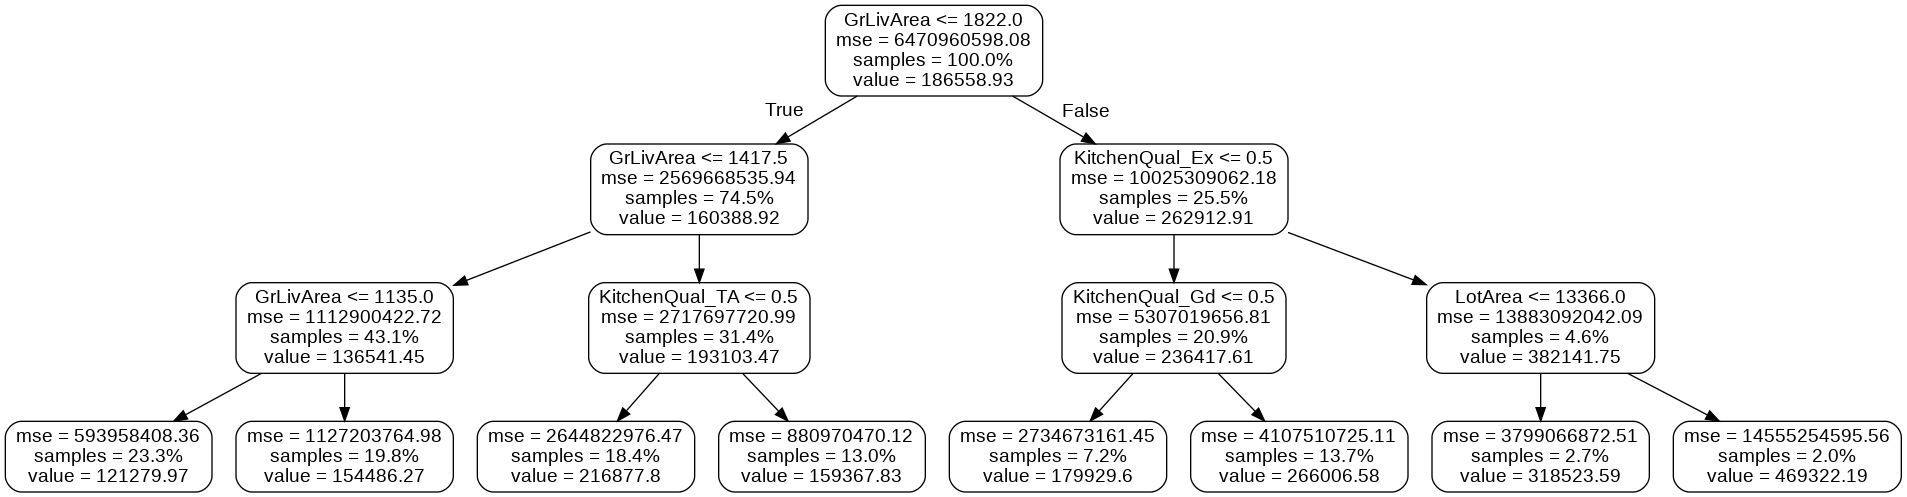

In [30]:
# Export as dot file
dot_data = export_graphviz(dt0, out_file=None, 
                        feature_names = X.columns,
                        rounded = True, proportion = True, 
                        precision = 2, filled = False, impurity = True)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

After we caculate the residuals from the first tree.

In [31]:
resid0 = Y - dt0.predict(X)
resid0

0       -8377.803150
1       27013.728938
2        6622.196850
3      -76877.803150
4      -16006.576720
            ...     
1455    15632.173184
1456    30070.404040
1457      493.423280
1458    20845.034268
1459    -6986.271062
Name: SalePrice, Length: 1379, dtype: float64

Now we assign weights to each sample according absolute residual (can be changed by making loss not linear).

In [0]:
weights = np.abs(resid0)/np.sum(np.abs(resid0))

In [33]:
weights.head()

0    0.000182
1    0.000587
2    0.000144
3    0.001670
4    0.000348
Name: SalePrice, dtype: float64

Here are 2 options either we resample data according to weights, or we then chose a weighted MSE. 2 approaches hold similar results. Let's go with resampling method.

In [0]:
selected_index = np.random.choice(weights.index,p=weights,size=len(weights))

In [0]:
X_new = X.loc[selected_index]

This is our new sample.

In [36]:
X_new.head()

,LotArea,GrLivArea,CentralAir_N,CentralAir_Y,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd
642,13860,2704,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0
1192,9600,1472,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
898,12919,2364,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
399,8125,1550,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0
1027,9520,1646,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0


Now we need to procced to the next tree, but before that there is also one more component in boosting. We can weigh the voting power of each tree by measuring how accurate they are with MSE.

The procces of weighing is iterative and follows the following algorithm:

$\text{for }i\text{ in range(}n+1\text{):}$<br>
$\quad\text{Caculate }MSE_i$<br>
$\quad\text{for }j\text{ in range(}i\text{):}$<br>
$\quad\quad\text{Assign voting power }v_j = \frac{\sum\limits_{i\ne j}{MSE_i}}{\sum\limits_{i}{MSE_i}}$<br><br>

After assigning initial vote, we proceed to build next model, and then refine all voting powers.

So after this modification AdaBoost will have the following algorithm.

$\text{Choose a family of models }{M(x)}$<br>
$\text{Choose number of iterations }{n}$<br><br>
$\text{for }\boldsymbol{i}\text{ in range(}{n+1}\text{):}$<br>
$\quad\text{fit a model }{M_i(x)}\text{ on }{y}$<br>
$\quad\text{Calculate the residual }{R_{i} = y-M_i(x)}$<br>
$\quad\text{Caculate }MSE_i$<br>
$\quad\text{for }j\text{ in range(}i+1\text{):}$<br>
$\quad\quad\text{Assign voting power }v_j = \frac{\sum\limits_{i\ne j}{MSE_i}}{\sum\limits_{i}{MSE_i}}$<br><br>
$\quad\text{Assign weights to datapoints according to }R_{i} \text{ and }v_i$<br>
$\quad\text{Either resample the data according to weights or use weigthed fit criterion on next iterations}$<br><br>
$\text{Final model is }\sum\limits_{i=0}^n{v_iM_i(x)}$


### Gradient Boosting

$\text{Choose a family of models }{M(x)}$<br>
$\text{Denote }{y}\text{ as }{R^0}$<br>
$\text{Choose number of iterations }{n}$<br><br>
$\text{for }{i}\text{ in range(}{n+1}\text{):}$<br>
$\quad\text{fit a model }{M_i(x)}\text{ on }{R^{i}}$<br>
$\quad\text{Calculate the residual }{R^{i+1}=\frac{1}{2}\sum\limits_{j=1}^n{(R_j-M(x_j))^2}'_{M(x_j)}}$<br><br>
$\text{Final model is }\sum\limits_{i=0}^n{M_i(x)}$

![alt text](https://s3.amazonaws.com/assets.datacamp.com/production/course_7714/datasets/Gradient_Boosting3.png)

_Note: the calculation of residual comes from taking the derivative of Loss function_

Gradient Boosting nicely and simply explained: https://www.youtube.com/watch?v=3CC4N4z3GJc

For Gradient Boosting voting power is equal for all trees and is called learning rate (There is also parameter learning rate in AdaBoost which is multiplied with $v_j$, while for Gradient Boosting all voting powers are equal). 

Gradient part of Boosting is coming from how the residuals are calculated.

As we are now solving a regression problem we can use the gradient of MSE to calculate the residuals.

$$Loss = \frac{1}{2}\sum\limits_{i=1}^n{(y_i-M(x_i))^2}$$
$$Loss'_{M(x_i)} = (y_i-M(x_i))$$

Which is the same residual, afterwards that residual is picked for prediction as mentioned in the algorithm in the beggining of this notebook.

In [0]:
# Simple fits and testing of R squared on 3 boosting techniques

In [38]:
!pip install catboost

In [0]:
from xgboost import XGBRegressor
from catboost import CatBoostRegressor,Pool
from lightgbm import LGBMRegressor

In [40]:
xgb = XGBRegressor()
xgb.fit(X,Y)
xgb.score(X,Y)

[07:03:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


0.8617213373445763

In [41]:
cat = CatBoostRegressor(silent=True,n_estimators=100)
cat.fit(X,Y)
cat.eval_metrics(Pool(X,Y),'R2')['R2'][-1]

0.7929690599290055

In [42]:
lgbm = LGBMRegressor()
lgbm.fit(X,Y)
lgbm.score(X,Y)

0.8747919958786168

Comparison of Boosting algos: https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db <br>
XGBoost paper: https://arxiv.org/pdf/1603.02754.pdf <br>
LGBM paper: https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree.pdf <br>
LGBM categorical: http://www.csiss.org/SPACE/workshops/2004/SAC/files/fisher.pdf <br>
CatBoost paper: https://arxiv.org/pdf/1706.09516.pdf <br>
Catboost categorical: http://helios.mm.di.uoa.gr/~rouvas/ssi/sigkdd/sigkdd.vol3.1/barreca.pdf